In [1]:
import numpy as np
def entropy(y):
    """
    Calculate the entropy of a dataset.
    y - array-like, target values
    """
    # Count the occurrences of each unique class
    class_counts = np.unique(y, return_counts=True)[1]
    # Probabilities for each class
    probabilities = class_counts / len(y)
    # Calculate entropy
    return -np.sum(probabilities * np.log2(probabilities))

def gini(y):
    """
    Calculate the Gini impurity of a dataset.
    y - array-like, target values
    """
    # Count the occurrences of each unique class
    class_counts = np.unique(y, return_counts=True)[1]
    # Probabilities for each class
    probabilities = class_counts / len(y)
    # Calculate Gini impurity
    return 1 - np.sum(probabilities**2)

In [21]:
from collections import defaultdict

def information_gain(y, y_split, criterion='entropy'):
    """
    Calculate the information gain of a split.
    y - array-like, target values before the split
    y_split - list of arrays, target values after the split
    criterion - string, either 'entropy' or 'gini'
    """
    # Calculate the initial criterion value
    if criterion == 'entropy':
        initial = entropy(y)
    else:
        initial = gini(y)

    # Weighted average of the criterion value after the split
    weighted_sum = sum([len(subset) / len(y) * (entropy(subset) if criterion == 'entropy' else gini(subset)) 
                        for subset in y_split])

    # Information gain is the reduction in the criterion
    return initial - weighted_sum

def split_data(data, feature):
    """
    Split the dataset based on the given feature.
    data - DataFrame, the dataset
    feature - string, the feature to split on
    """
    # Dictionary to hold the subsets
    subsets = defaultdict(list)
    for _, row in data.iterrows():
        subsets[row[feature]].append(row)
    return [pd.DataFrame(subset) for subset in subsets.values()]

def id3(data, target, features, criterion='entropy'):
    """
    Recursive ID3 algorithm.
    data - DataFrame, the dataset
    target - string, the target attribute
    features - list of strings, the feature names
    criterion - string, either 'entropy' or 'gini'
    """
    # If all target values are the same, return this value
    if len(set(data[target])) == 1:
        return data[target].iloc[0]

    # If no feature is left, return the most common target value
    if not features:
        return data[target].mode()[0]

    # Calculate information gain for each feature
    gains = []
    for feature in features:
        subsets = split_data(data, feature)
        y_subsets = [subset[target].values for subset in subsets]
        gain = information_gain(data[target].values, y_subsets, criterion)
        gains.append((gain, feature))
    # Sort features by information gain
    gains.sort(reverse=True)
    # If the highest gain is not unique, we need to consider multiple trees
    max_gain = gains[0][0]
    best_features = [feature for gain, feature in gains if gain == max_gain]

    trees = {}
    for best_feature in best_features:
        # The current best feature
        subsets = split_data(data, best_feature)
        trees[best_feature] = {}
        
        # Recursive call for each subset
        for subset in subsets:
            subtree = id3(subset, target, [feat for feat in features if feat != best_feature], criterion)
            trees[best_feature][subset[best_feature].iloc[0]] = subtree

    return trees

def id3_with_layer_info(data, target, features, criterion='entropy', depth=0, layer_info=None):
    """
    Recursive ID3 algorithm with layer information.
    data - DataFrame, the dataset
    target - string, the target attribute
    features - list of strings, the feature names
    criterion - string, either 'entropy' or 'gini'
    depth - the current depth of the tree
    layer_info - dictionary to store layer-wise information
    """
    if layer_info is None:
        layer_info = defaultdict(float)

    # If all target values are the same, return this value
    if len(set(data[target])) == 1:
        return data[target].iloc[0], layer_info

    # If no feature is left, return the most common target value
    if not features:
        return data[target].mode()[0], layer_info

    # Calculate information gain for each feature
    gains = []
    for feature in features:
        subsets = split_data(data, feature)
        y_subsets = [subset[target].values for subset in subsets]
        gain = information_gain(data[target].values, y_subsets, criterion)
        gains.append((gain, feature))

    # Sort features by information gain
    gains.sort(reverse=True)

    # If the highest gain is not unique, we need to consider multiple trees
    max_gain = gains[0][0]
    best_features = [feature for gain, feature in gains if gain == max_gain]

    trees = {}
    for best_feature in best_features:
        # The current best feature
        subsets = split_data(data, best_feature)
        trees[best_feature] = {}
        
        # Update layer information
        layer_info[depth] += max_gain

        # Recursive call for each subset
        for subset in subsets:
            subtree, updated_layer_info = id3_with_layer_info(subset, target, [feat for feat in features if feat != best_feature], criterion, depth + 1, layer_info)
            trees[best_feature][subset[best_feature].iloc[0]] = subtree

        layer_info = updated_layer_info

    return trees, layer_info

# Run ID3 on the dataset with layer information

# Display the layer information


import pandas as pd
# Run ID3 on the dataset
features = ['x1', 'x2', 'x3', 'x4']
target = 'y'
data = pd.read_csv('tree_data.csv')
entropy_trees = id3(data, target, features, criterion='entropy')
gini_trees =  id3(data, target, features, criterion='gini')

# with layer info
heuristic_entropy_tree, entropy_layer_info = id3_with_layer_info(data, target, features, criterion='entropy')
heuristic_gini_tree, gini_layer_info = id3_with_layer_info(data, target, features, criterion='gini')

entropy_trees, gini_trees, 



({'x4': {0: {'x1': {1: {'x3': {1: 1, 0: -1}},
     0: {'x3': {0: {'x2': {1: 1, 0: -1}}, 1: -1},
      'x2': {1: {'x3': {0: 1, 1: -1}}, 0: -1}}}},
   1: {'x3': {0: 1,
     1: {'x2': {0: {'x1': {1: -1}}}, 'x1': {1: {'x2': {0: -1}}}}},
    'x2': {1: 1, 0: {'x3': {1: {'x1': {1: -1}}}, 'x1': {1: {'x3': {1: -1}}}}},
    'x1': {0: 1,
     1: {'x3': {1: {'x2': {0: -1}}}, 'x2': {0: {'x3': {1: -1}}}}}}},
  'x2': {0: {'x3': {1: {'x1': {1: {'x4': {0: 1, 1: -1}}, 0: -1}}, 0: -1},
    'x1': {1: {'x3': {1: {'x4': {0: 1, 1: -1}}, 0: -1}}, 0: -1}},
   1: {'x3': {0: 1, 1: -1}}}},
 {'x4': {0: {'x1': {1: {'x3': {1: 1, 0: -1}},
     0: {'x3': {0: {'x2': {1: 1, 0: -1}}, 1: -1},
      'x2': {1: {'x3': {0: 1, 1: -1}}, 0: -1}}}},
   1: {'x3': {0: 1,
     1: {'x2': {0: {'x1': {1: -1}}}, 'x1': {1: {'x2': {0: -1}}}}},
    'x2': {1: 1, 0: {'x3': {1: {'x1': {1: -1}}}, 'x1': {1: {'x3': {1: -1}}}}},
    'x1': {0: 1,
     1: {'x3': {1: {'x2': {0: -1}}}, 'x2': {0: {'x3': {1: -1}}}}}}},
  'x2': {0: {'x3': {1: {'x1': {1:

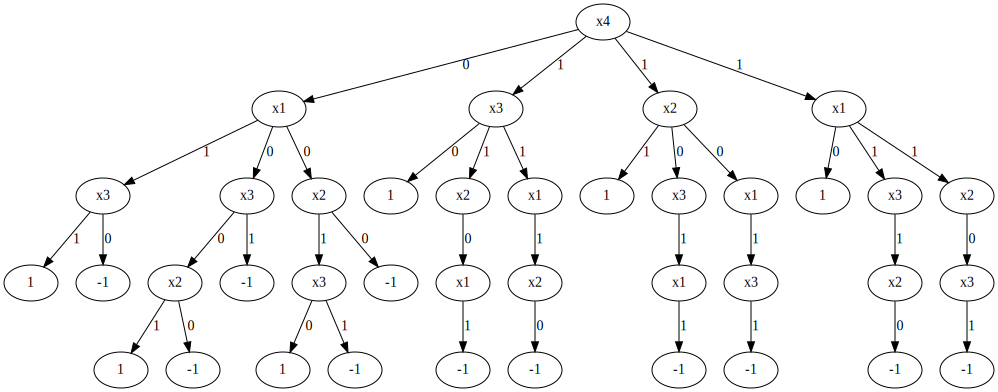

In [22]:
from graphviz import Digraph

def visualize_tree(tree, parent_name, graph, counter):
    """
    Recursive function to visualize a decision tree.
    tree - the decision tree to visualize
    parent_name - name of the parent node
    graph - graphviz Digraph object
    counter - a counter to create unique node names
    """
    if not isinstance(tree, dict):
        # If the tree is a leaf node
        node_name = f'{parent_name}_leaf_{tree}'
        graph.node(node_name, str(tree))
        graph.edge(parent_name, node_name)
        return counter

    for feature_value, subtree in tree.items():
        node_name = f'{parent_name}_{feature_value}_{counter}'
        graph.node(node_name, str(feature_value))
        graph.edge(parent_name, node_name)
        counter = visualize_tree(subtree, node_name, graph, counter + 1)

    return counter

def visualize_tree_simplified(tree, parent_name, graph, counter, parent_value=""):
    """
    Recursive function to visualize a decision tree without intermediate nodes.
    tree - the decision tree to visualize
    parent_name - name of the parent node
    graph - graphviz Digraph object
    counter - a counter to create unique node names
    parent_value - the value leading to the current node (for edge label)
    """
    if not isinstance(tree, dict):
        # If the tree is a leaf node
        node_name = f'{parent_name}_leaf_{tree}_{counter}'
        graph.node(node_name, str(tree))
        graph.edge(parent_name, node_name, label=str(parent_value))
        return counter

    for feature_value, subtree in tree.items():
        if isinstance(subtree, dict):
            # For decision nodes
            for sub_feature, sub_tree in subtree.items():
                node_name = f'{parent_name}_{sub_feature}_{counter}'
                graph.node(node_name, sub_feature)
                graph.edge(parent_name, node_name, label=str(feature_value))
                counter = visualize_tree_simplified(sub_tree, node_name, graph, counter + 1)
        else:
            # For leaf nodes
            node_name = f'{parent_name}_leaf_{subtree}_{counter}'
            graph.node(node_name, str(subtree))
            graph.edge(parent_name, node_name, label=str(feature_value))
            counter += 1

    return counter

def create_simplified_trees_visualization(decision_trees, criterion):
    """
    Create visualizations for all decision trees without intermediate nodes.
    decision_trees - dictionary of decision trees
    criterion - string, either 'entropy' or 'gini'
    """
    visualizations = []
    for feature, tree in decision_trees.items():
        graph = Digraph(comment=f'Simplified Decision Tree using {criterion} - Root: {feature}')
        graph.node(name=f'root_{feature}', label=feature)
        visualize_tree_simplified(tree, f'root_{feature}', graph, 1)
        visualizations.append(graph)

    return visualizations

# Create the simplified visualizations for the decision trees
# Create the visualizations for the decision trees
trees_visualizations_entropy = create_simplified_trees_visualization(entropy_trees, 'entropy')
trees_visualizations_gini = create_simplified_trees_visualization(gini_trees, 'gini')
vis_heur_entr = create_simplified_trees_visualization(heuristic_entropy_tree, 'entropy')
vis_heur_gini = create_simplified_trees_visualization(heuristic_gini_tree, 'entropy')

# Display the first tree as an example (there might be several trees)
trees_visualizations_entropy[0]


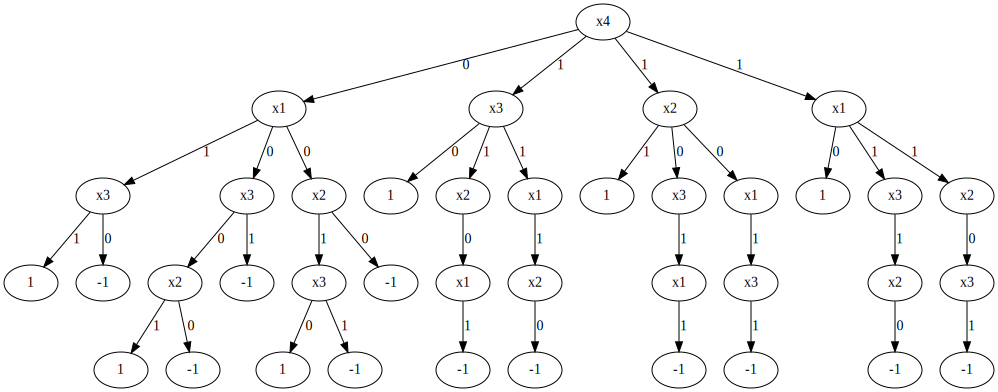

In [24]:
vis_heur_entr[0]

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path

# Directory for saving the tree images
image_dir = Path("decision_trees")
image_dir.mkdir(exist_ok=True)

# Function to save each tree visualization as an image
def save_tree_images(trees_visualizations, criterion, image_dir):
    image_paths = []
    for i, tree_visualization in enumerate(trees_visualizations):
        image_path = image_dir / f"decision_tree_{criterion}_{i}.png"
        tree_visualization.render(image_path, format='png', cleanup=True)
        image_paths.append(image_path)
    return image_paths

# Save the images for entropy criterion
image_paths_entropy = save_tree_images(trees_visualizations_entropy, 'entropy', image_dir)
image_paths_gini = save_tree_images(trees_visualizations_gini, 'gini', image_dir)

image_paths_entropy, image_paths_gini



([PosixPath('decision_trees/decision_tree_entropy_0.png'),
  PosixPath('decision_trees/decision_tree_entropy_1.png')],
 [PosixPath('decision_trees/decision_tree_gini_0.png'),
  PosixPath('decision_trees/decision_tree_gini_1.png')])

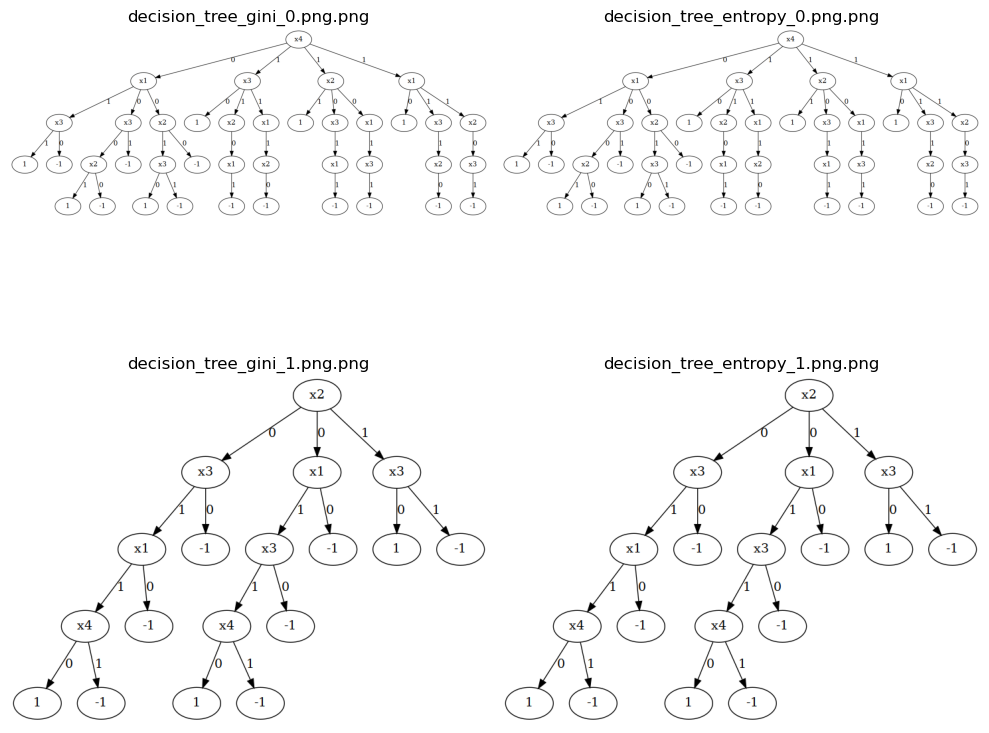

In [18]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to the folder containing the decision tree images
folder_path = 'decision_trees/'

# List of image file names in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]

# Determine the grid size (rows x cols) for plotting
n_cols = 2  # Number of columns, you can adjust this based on your preference
n_rows = len(image_files) // n_cols + (1 if len(image_files) % n_cols else 0)

# Create a grid of subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 5))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Plot each image in the grid
for idx, file in enumerate(image_files):
    img_path = os.path.join(folder_path, file)
    img = mpimg.imread(img_path)
    axes[idx].imshow(img)
    axes[idx].set_title(file)
    axes[idx].axis('off')

# Turn off any unused subplots
for idx in range(len(image_files), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

